In [37]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [38]:
from tsnecuda import TSNE
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_single_embedding(args):
    emb_path, file = args
    return np.load(os.path.join(emb_path, file))

def load_embeddings(emb_path: str, file_list: list, meta_df: pd.DataFrame, num_workers: int=4):
    '''
    Load embeddings from a list of files in parallel.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns should include 'file' and 'label'.
        num_workers (int): Number of workers to use for parallel processing.
    Returns:
        emb (np.array): Array of embeddings.
        labels (np.array): Array of labels.
    '''
    def load_file(file: str):
        file_path = os.path.join(emb_path, file)
        embedding = np.load(file_path)
        file_ = file.split('.')[0]
        label = meta_df.loc[meta_df['filename'] == file_, 'label'].values[0]
        return embedding, label

    embeddings = []
    labels = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, file): file for file in file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, label = future.result()
            if emb is not None and label is not None:
                embeddings.append(emb)
                labels.append(label)

    return np.array(embeddings), np.array(labels)

# Perform t-SNE
def perform_tsne(embeddings):
    print(f"Original embedding shape: {embeddings.shape}")
    
    # Take the mean of each embedding if it's 3D
    if len(embeddings.shape) == 3:
        # Flatten the embeddings to 2D, keep the first dimension
        # For example, if the shape is (1000, 10, 256), it will be reshaped to (1000, 2560)
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
        print(f"Reshaped embedding shape: {embeddings.shape}")
    
    # Standardize the features
    # scaler = StandardScaler()
    # embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_seed=42, device=2)
    tsne_results = tsne.fit_transform(embeddings)
    print(f"t-SNE results shape: {tsne_results.shape}")
    
    return tsne_results

# Plot t-SNE results
def plot_tsne(tsne_results, labels, title="t-SNE Visualization of Embeddings", figsize=(12, 8)):
    print(f"t-SNE results shape: {tsne_results.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Unique labels: {np.unique(labels)}")
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = sns.color_palette("husl", n_colors=len(unique_labels))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                   c=[color], label=label, alpha=0.6)
    
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    return plt


In [39]:

emb_1s_path = 'emb_last/16000'
emb_2s_path = 'emb_last/32000'
emb_3s_path = 'emb_last/48000'
emb_4s_path = 'emb_last/66800'
file_list = os.listdir(emb_1s_path)

# Read and prepare labels
df21 = pd.read_csv(
    '/data/hungdx/Lightning-hydra/logs/asvspoof-challenge-2021/eval-package/keys/DF/CM/trial_metadata.txt',
    sep=' ',
    header=None
)
df21 = df21[[1, 5]]
df21.columns = ['filename', 'label']

# Prepare file list
file_list_df = pd.DataFrame(file_list, columns=['filename'])
file_list_df['filename'] = file_list_df['filename'].apply(lambda x: x.split('.')[0])

# Merge to get labels
merge_df = pd.merge(df21, file_list_df, on='filename', how='inner')

print(f"Number of files: {len(file_list)}")
print(f"Number of labels after merge: {len(merge_df)}")

Number of files: 10000
Number of labels after merge: 10000


In [40]:
# Load embeddings
embeddings_1s, labels_1s = load_embeddings(emb_1s_path, file_list, merge_df)
embeddings_2s, labels_2s = load_embeddings(emb_2s_path, file_list, merge_df)
embeddings_3s, labels_3s = load_embeddings(emb_3s_path, file_list, merge_df)
embeddings_4s, labels_4s = load_embeddings(emb_4s_path, file_list, merge_df)


Loading embeddings: 100%|██████████| 10000/10000 [00:22<00:00, 447.85it/s]


In [41]:
print("embedding 1s shape: ", embeddings_1s.shape)
print("embedding 2s shape: ", embeddings_2s.shape)
print("embedding 3s shape: ", embeddings_3s.shape)
print("embedding 4s shape: ", embeddings_4s.shape)

embedding 1s shape:  (10000, 144)
embedding 2s shape:  (10000, 144)
embedding 3s shape:  (10000, 144)
embedding 4s shape:  (10000, 144)


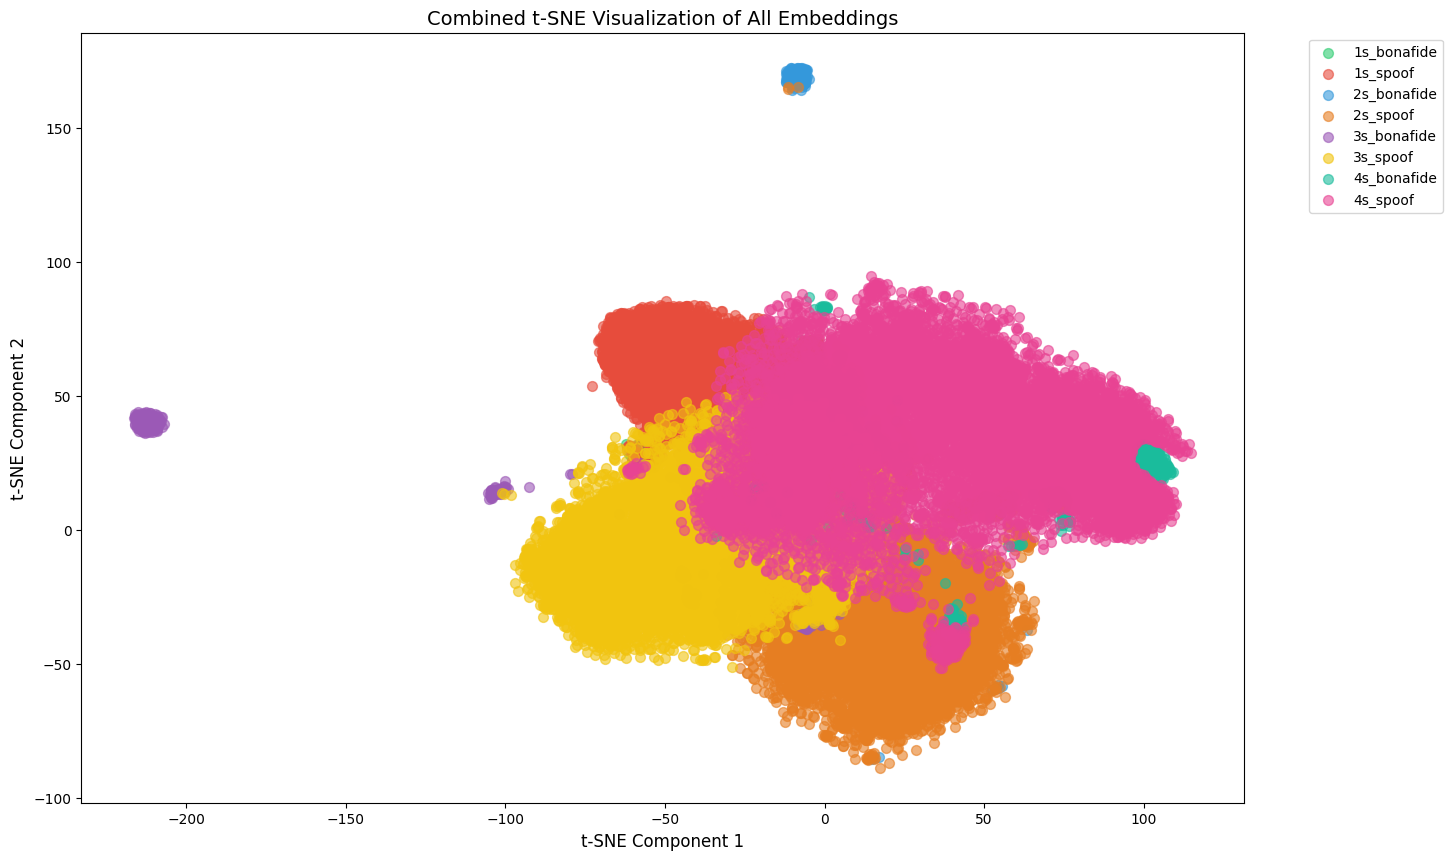

<Figure size 640x480 with 0 Axes>

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
        '1s_bonafide': '#2ecc71', '1s_spoof': '#e74c3c',
        '2s_bonafide': '#3498db', '2s_spoof': '#e67e22',
        '3s_bonafide': '#9b59b6', '3s_spoof': '#f1c40f',
        '4s_bonafide': '#1abc9c', '4s_spoof': '#e84393'
    }
    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(zip(embeddings_list, labels_list, names_list)):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{name}_{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    # Create scatter plot
    for label in np.unique(combined_labels):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings_1s, embeddings_2s, embeddings_3s, embeddings_4s]
labels_list = [labels_1s, labels_2s, labels_3s, labels_4s]
names_list = ['1s', '2s', '3s', '4s']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
plt.savefig('embeddings_tsne_xlsr_conformertcm.png', dpi=300, bbox_inches='tight')
# plt.close()

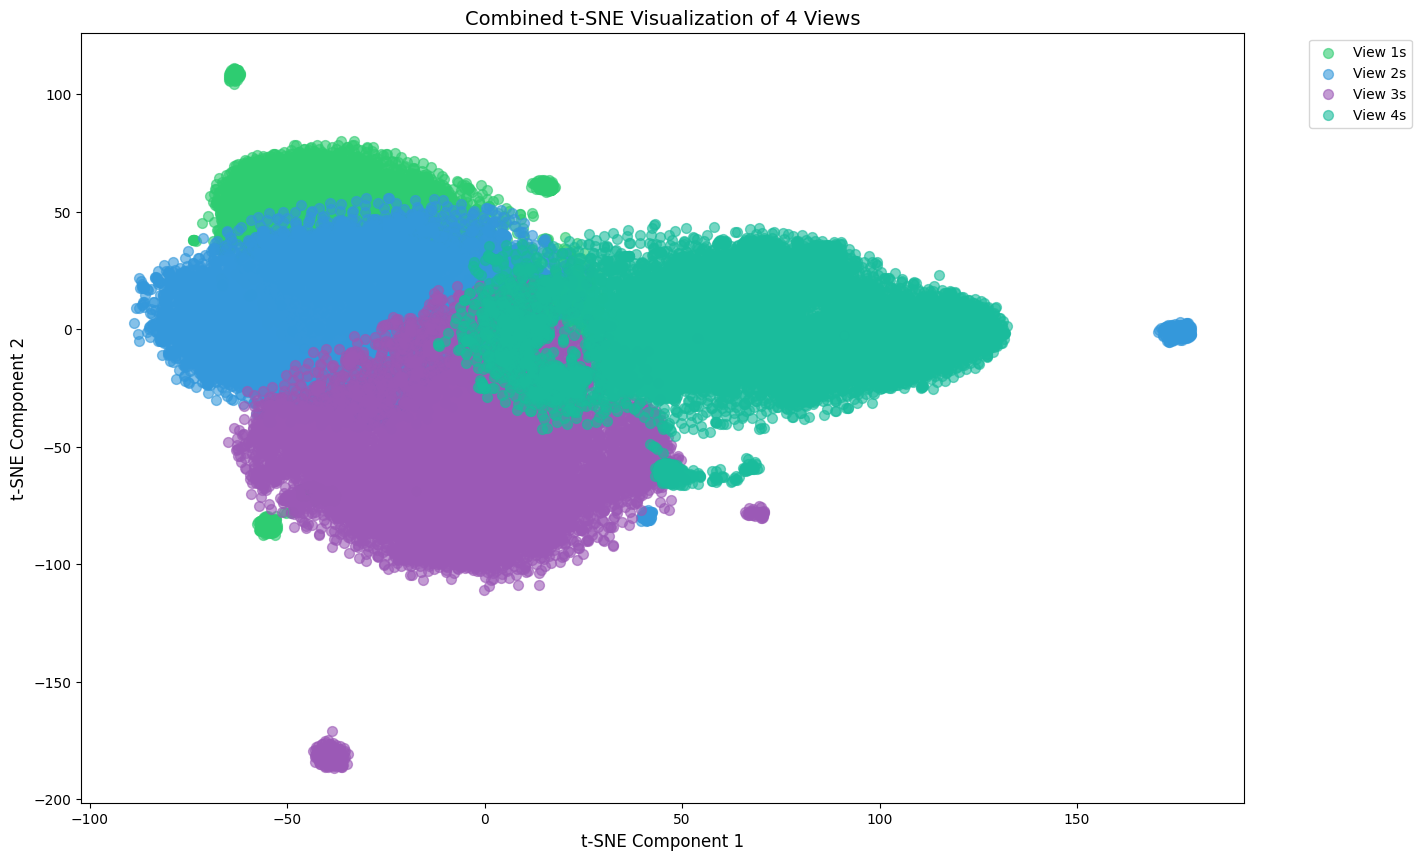

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with 4 different views.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Define colors for each view
    view_colors = {
        '1s': '#2ecc71',  # green
        '2s': '#3498db',  # blue
        '3s': '#9b59b6',  # purple
        '4s': '#1abc9c'   # turquoise
    }
    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_views = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(zip(embeddings_list, labels_list, names_list)):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42
        )
        embeddings_tsne = tsne.fit_transform(embeddings_scaled)
        
        # Store results
        all_tsne.append(embeddings_tsne)
        all_views.extend([name] * len(embeddings))
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_views = np.array(all_views)
    
    # Create scatter plot for each view
    for view in names_list:
        view_mask = combined_views == view
        plt.scatter(
            combined_tsne[view_mask, 0],
            combined_tsne[view_mask, 1],
            c=view_colors[view],
            label=f'View {view}',
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of 4 Views', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Example usage:
embeddings_list = [embeddings_1s, embeddings_2s, embeddings_3s, embeddings_4s]
labels_list = [labels_1s, labels_2s, labels_3s, labels_4s]
names_list = ['1s', '2s', '3s', '4s']

fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)
plt.show()
#plt.savefig('embeddings_tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.close()

# full

In [44]:
emb_full = 'emb_last/full'
embeddings_full, labels_full = load_embeddings(emb_full, file_list, merge_df)

Loading embeddings: 100%|██████████| 10000/10000 [00:18<00:00, 528.15it/s]


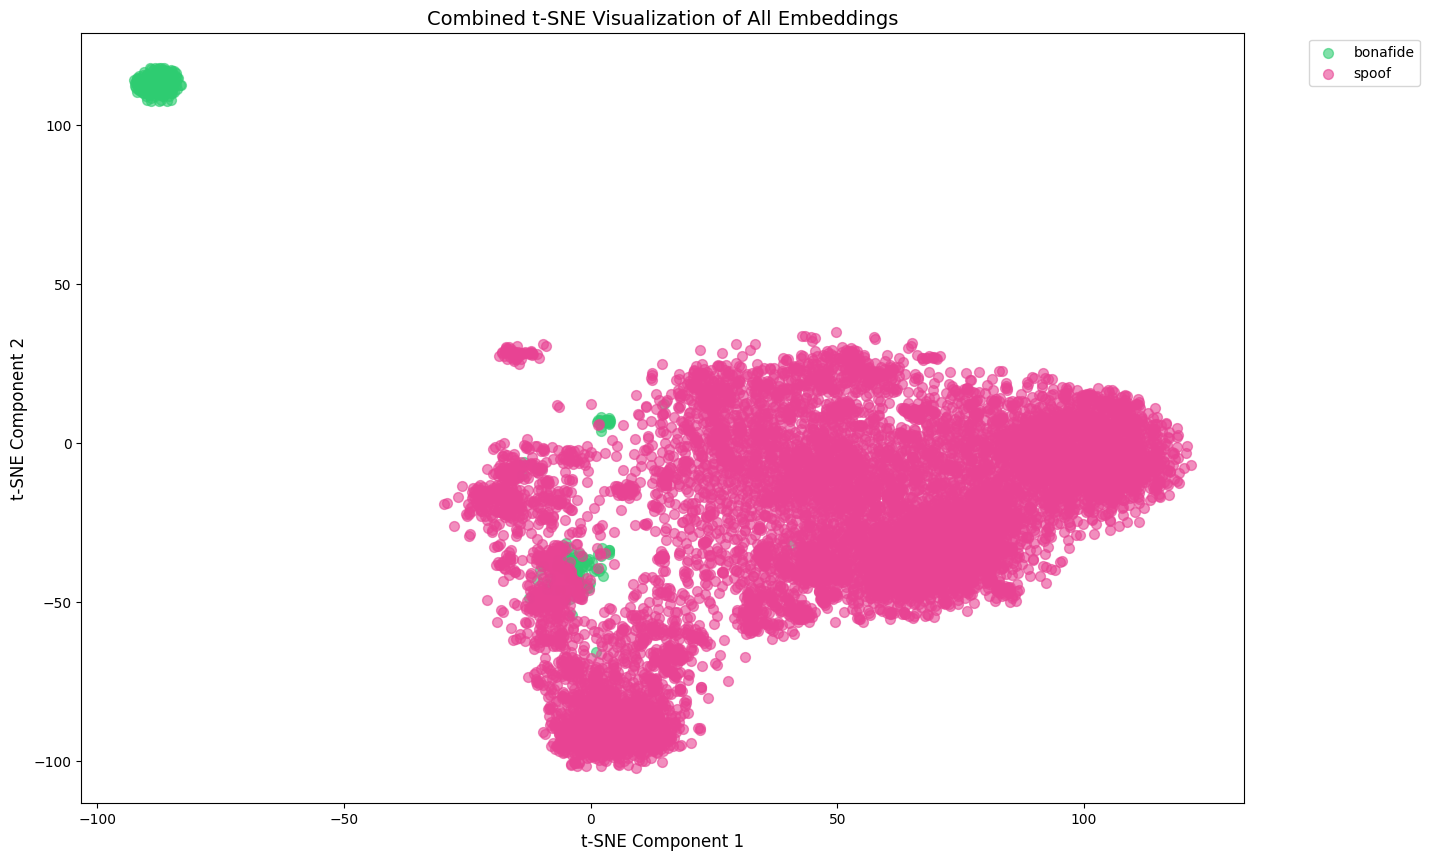

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

np.random.seed(42)

def visualize_embeddings_single(embeddings_list, labels_list, names_list):
    """
    Visualize multiple embeddings using t-SNE in a single figure with modified labels.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        names_list: List of names for each embedding
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette - different colors for each view and class
    colors = {
        'bonafide': '#2ecc71', 
        'spoof': '#e84393'
    }
    
    # Initialize lists to store all t-SNE results
    all_tsne = []
    all_labels = []
    
    # Process each embedding
    for idx, (embeddings, labels, name) in enumerate(zip(embeddings_list, labels_list, names_list)):
        # Standardize the embeddings
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply t-SNE
        tsne = TSNE(
            n_components=2,
            random_seed=42,
  
        )
        embeddings_tsne = tsne.fit_transform(embeddings)
        
        # Store results with modified labels
        all_tsne.append(embeddings_tsne)
        modified_labels = np.array([f'{label}' for label in labels])
        all_labels.append(modified_labels)
    
    # Combine all results
    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)
    
    # Create scatter plot
    for label in np.unique(combined_labels):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors[label]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    plt.title('Combined t-SNE Visualization of All Embeddings', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    
    return plt.gcf()

# Prepare the data
embeddings_list = [embeddings_full]
labels_list = [labels_full]
names_list = ['full-length']

# Create the visualization
fig = visualize_embeddings_single(embeddings_list, labels_list, names_list)

# Save the figure
plt.show()
